# Explore Gaussian Processes

In [127]:
import pandas as pd
import numpy as np
import feather

df = (feather.read_dataframe('/home/SHARED/SOLAR/data/oahu_min.feather')
             .set_index('Datetime'))

info = pd.read_csv('/home/SHARED/SOLAR/data/info.csv')
info['Location'] = info['Location'].str.replace('(HL)?_', '')
info.set_index('Location', inplace=True)

We just work with GH radiation for the moment. We also normalize sensor names.

In [128]:
df.drop(list(df.filter(regex = 'GT_')), axis = 1, inplace = True)
df.columns = df.columns.str.replace('GH_', '')

In [129]:
"""
Returns the training set for the GP, that is the value and location 
of all sensors at a given time
"""
def get_training_set(time='2010-03-19 14:15:00'):
    im = info[['Latitude','Longitude']]
    im['Radiation'] = df.loc[tt]
    return im

## Train GP

In [130]:
from sklearn.datasets import make_friedman2
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

time = '2010-03-19 14:15:00'
im = get_training_set(time)
X = im[['Latitude','Longitude']].values
y = im['Radiation'].values

#kernel = DotProduct() + WhiteKernel()
kernel = C(1.0, (1e-3, 1e3)) * RBF(10, (1e-2, 1e2))

gpr = GaussianProcessRegressor(kernel=kernel,n_restarts_optimizer=9)
gpr.fit(X, y)

gpr.predict(X[:2,:], return_std=True) 


/usr/local/lib/python3.6/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


(array([593.29190135, 772.94208002]), array([0.        , 0.00586141]))

## Interpolate in a given grid

In [131]:
def get_grid(latmin, latmax, stepsize):
    long_range = np.arange(lonmin, lonmax, stepsize)
    lat_range = np.arange(latmin, latmax, stepsize)
    latlon =  np.transpose([np.tile(lat_range, len(long_range)), np.repeat(long_range, len(lat_range))])
    grid = pd.DataFrame(latlon, columns=["Latitude", "Longitude"])
    return grid

In [132]:
latmin =  np.min(im.Latitude) - 0.0001
latmax =  np.max(im.Latitude) + 0.0001
lonmin = np.min(im.Longitude) - 0.0001
lonmax = np.max(im.Longitude) + 0.0001
stepsize = 0.0001

grid = get_grid(latmin, latmax, stepsize)

In [133]:
X_test = grid.values
(y_pred, std_pred) = gpr.predict(X_test, return_std=True)

/usr/local/lib/python3.6/dist-packages/sklearn/gaussian_process/gpr.py:335: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


In [137]:
grid['prediction'] = y_pred
grid['stds'] = std_pred

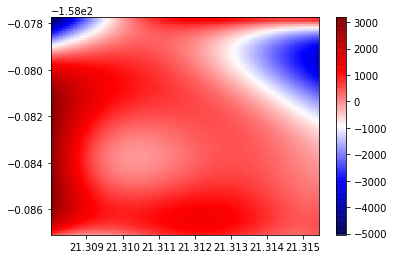

In [138]:
import seaborn as sns
plt.scatter(grid.Latitude, grid.Longitude, alpha = .8, c = grid.prediction, cmap = 'seismic')
plt.ylim(lonmin,lonmax)
plt.xlim(latmin,latmax)
cbar = plt.colorbar()

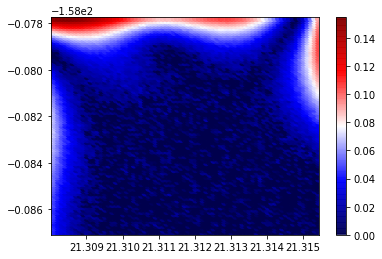

In [139]:
plt.scatter(grid.Latitude, grid.Longitude, alpha = .8, c = grid.stds, cmap = 'seismic')
plt.ylim(lonmin,lonmax)
plt.xlim(latmin,latmax)
cbar = plt.colorbar()

We should play with hyperparameters of the Kernel!! Standard deviation is clearly understimated.